# Kaggle's Titanic Competition

https://www.kaggle.com/competitions/titanic

Note to self: I actually did most of this as homework for the Machine Learning class from FSU's Engineering in 2021

In [24]:
import os
import regex
import string
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython import get_ipython
from pathlib import Path
from pprint import pprint
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Notebook-wide variables
datasetsPath = "data"
figure_width = 18
figure_height = 12

## Training Data

In [25]:
# Load training data
trainfname = "train.csv"
trainpath = os.path.join(datasetsPath, trainfname)
traindata0 = pd.read_csv(trainpath, index_col=0)

### Convert all string categorical variables to integer categorical values, i.e. One-Hot Encoding

Before we can use One-Hot encoding, we must handle missing values, because Sci-kitLearn's One-Hot Encoder can't handle `NaN`s. Only the `Age`, `Cabin`, and `Embarked` variables have `NaN`s in the training data. Note their frequencies

In [26]:
print(traindata0.isna().sum())

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64


#### Missing Value: `Cabin`
Because Cabin is specific to each passenger, it does not have much predictive power for new cases, unless we were to extract the level from each value. E.g., C level for cabins C23, C25, and C27.


In [27]:
def extractCabinLevels(dataframe):
    cabins = dataframe["Cabin"].dropna()
    pattern = r"(\w)\d*"
    index = []
    levels = []
    for it, string in cabins.iteritems():
        cabins = regex.findall(pattern, string)
        index.append(it)
        # levels.append(', '.join(cabins))
        levels.append(set(cabins))
    levels = pd.Series(levels, index=index)
    return levels


alphabet2numbers = {alpha: numeric for (numeric, alpha) in enumerate(string.ascii_uppercase[:], start=1)}


def convertCabinLevels(cabinAsSet):
    """
    Uses `alphabet2numbers` defined outside function
    """
    nums = [alphabet2numbers[char] for char in cabinAsSet]
    return np.mean(nums)


traindata1 = traindata0.copy()
levels_train = extractCabinLevels(traindata1)
print(levels_train)

2      {C}
4      {C}
7      {E}
11     {G}
12     {C}
      ... 
872    {D}
873    {B}
880    {C}
888    {B}
890    {C}
Length: 204, dtype: object


We further investigate to see if there are instances of multi-level tickets.

In [28]:
pprint(sorted(levels_train.apply(lambda x: ', '.join(x)).unique()))

['A', 'B', 'C', 'D', 'E', 'E, F', 'F', 'G', 'G, F', 'T']


After extracting the cabin levels we see that only three cases have multiple levels, these are passengers 76, 700, and 716. For this reason, and because the train and test set have different cabin levels, we will convert this variable into a quantitative one, assuming that the levels represent and ordinal variable.

In [29]:
levels_quant_train = levels_train.apply(convertCabinLevels)

We replace the values thus:

In [30]:
traindata1.loc[levels_quant_train.index, "Cabin"] = levels_quant_train.values

As for the missing values, note that the correlation of converted values is with `Fare` is negative. So A (and thus lower numeric values), are worth more. So we assume those not assigned Cabins are because they had lower value tickets. With this logic in mind we assign missing values a numeric value one integer above the maximum ordinal value.

In [31]:
max_ord_val = len(alphabet2numbers)+1  # 27
traindata1["Cabin"] = traindata1["Cabin"].fillna(max_ord_val)

#### Missing Value: `Embarked`
Since there are only three values for `Embarked`, we can simply replace the missing values with a dummy value, the string `None`, to create a fourth category.

In [32]:
traindata1["Embarked"] = traindata1["Embarked"].fillna("Embarked_None")

#### Missing value: `Age`
Since the `Age` variable is quantitative, creating a dummy value would not be as useful in this case. Instead, we must find another substitute value. We would prefer to bootstrap the missing values, but will instead use the median age.


In [33]:
medianAge_train = traindata1["Age"].median()
traindata1["Age"] = traindata1["Age"].fillna(medianAge_train)

#### Missing value: `Fare`
The training set has no missing values for this variable, but the test set does. This will be handled later.

#### One-Hot Encoding
Next we encode the nominal values using the one-hot encoder from `sklearn`.


In [34]:
ohe = OneHotEncoder(sparse=False)
varsToEncode = ["Sex", "Embarked"]
encs_train = ohe.fit_transform(traindata1[varsToEncode])
columns1_train = [f"{var}_{category}" for var, array in zip(varsToEncode, ohe.categories_) for category in array]
encdf_train = pd.DataFrame(encs_train, index=traindata1.index, columns=columns1_train)

Exclude the encoded columns

In [35]:
columns2_train = traindata1.columns.difference(columns1_train)
traindata = pd.concat([traindata1[columns2_train], encdf_train], axis=1)

### Select Regressors
We select the variables to use in our analysis. First, we note that the ticket values are alphanumeric. However, this in itself is not a reason to discard teh variable. The concern is that the ticket values are almost exactly unique to each passenger, which provides little inferential value. We also drop `Name` for this reason.

In [36]:
xcolumns = traindata.columns.difference({"Survived",
                                         "Name",
                                         "Ticket"}.union(varsToEncode))

X_train0 = traindata[xcolumns]
y_train = traindata["Survived"]

### Standardize

In [37]:
scaler = StandardScaler().fit(X_train0)
X_train = pd.DataFrame(scaler.transform(X_train0), index=X_train0.index, columns=X_train0.columns)

## Test Data

In [38]:
testfname = "test.csv"
testpath = os.path.join(datasetsPath, testfname)
testdata0 = pd.read_csv(testpath, index_col=0)

### One-Hot Encoding
We process the test data the same as we the training data: replace missing values, convert ordinal values, and encode categorical values

In [39]:
testdata1 = testdata0.copy()
levels_test = extractCabinLevels(testdata1)
levels_quant_test = levels_test.apply(convertCabinLevels)

Compare unique Cabin level values from train and test sets

In [40]:
pprint(sorted(pd.Series([",".join(s) for s in levels_test]).unique()))
pprint(sorted(pd.Series([",".join(s) for s in levels_train]).unique()))

['A', 'B', 'C', 'D', 'E', 'E,F', 'F', 'G', 'G,F']
['A', 'B', 'C', 'D', 'E', 'E,F', 'F', 'G', 'G,F', 'T']


We replace the values thus:

In [41]:
testdata1.loc[levels_quant_test.index, "Cabin"] = levels_quant_test.values
testdata1["Cabin"] = testdata1["Cabin"].fillna(len(alphabet2numbers)+1)
testdata1["Embarked"] = testdata1["Embarked"].fillna("Embarked_None")

medianAge_test = testdata1["Age"].median()
testdata1["Age"] = testdata1["Age"].fillna(medianAge_test)

medianFare_test = testdata1["Fare"].median()
testdata1["Fare"] = testdata1["Fare"].fillna(medianFare_test)

Encode nominal values

In [42]:
encs_test = ohe.transform(testdata1[varsToEncode])
columns1_test = [f"{var}_{category}" for var, array in zip(varsToEncode, ohe.categories_) for category in array]
encdf_test = pd.DataFrame(encs_test, index=testdata1.index, columns=columns1_test)

columns2_test = testdata1.columns.difference(varsToEncode)
testdata = pd.concat([testdata1[columns2_test], encdf_test], axis=1)

### Select regressors

In [43]:
X_test0 = testdata[xcolumns]

### Standardize

In [44]:
X_test = pd.DataFrame(scaler.transform(X_test0), index=X_test0.index, columns=X_test0.columns)

## Model-building
We will compare the results of a logistic regression model and a random forest model.
### Logistic Regression
#### Train

In [46]:
model1 = LogisticRegression().fit(X_train, y_train)

#### Predict

In [47]:
accuracy1 = model1.score(X_train, y_train)

y_hat_train1 = model1.predict(X_train)
accuracy2 = np.mean(y_hat_train1 == y_train)

print(accuracy1 == accuracy2)  # True

True


In [48]:
xcolsa = ", ".join(xcolumns[:-1])
xcolsb = xcolumns[-1]
print(f"We used sklearn's package to perform logistic regression on the variables {xcolsa}, and {xcolsb} to achieve a TRAINING accuracy of {accuracy1:0.4f}")

We used sklearn's package to perform logistic regression on the variables Age, Cabin, Embarked_C, Embarked_Embarked_None, Embarked_Q, Embarked_S, Fare, Parch, Pclass, Sex_female, Sex_male, and SibSp to achieve a TRAINING accuracy of 0.7991


### Random Forest
#### Train & Predict

In [49]:
model2 = RandomForestClassifier()
model2.fit(X_train, y_train)
y_hat_train2 = model2.predict(X_train)
y_hat_test2 = model2.predict(X_test)

train_acc = np.sum(y_train == y_hat_train2)

### Comparison of Results
The confusion matrices and ROC curves provide a visual measures of each model's performance.
#### Confusion matrices
Recall the confusion matrix layout is:
|||
|-|-|
|TP|FN|
|FP|TN|

In [50]:
conf_mat1 = pd.DataFrame(metrics.confusion_matrix(y_train, y_hat_train1), columns=["Pred. Positive", "Pred. Negative"], index=["True Positive", "True Negative"])
print(conf_mat1)
conf_mat2 = pd.DataFrame(metrics.confusion_matrix(y_train, y_hat_train2), columns=["Pred. Positive", "Pred. Negative"], index=["True Positive", "True Negative"])
print(conf_mat2)

               Pred. Positive  Pred. Negative
True Positive             469              80
True Negative              99             243
               Pred. Positive  Pred. Negative
True Positive             547               2
True Negative              13             329


#### ROC Curves
The ROC curve is made from the training set, because we need the true $y$ values, which are not available for the test set.

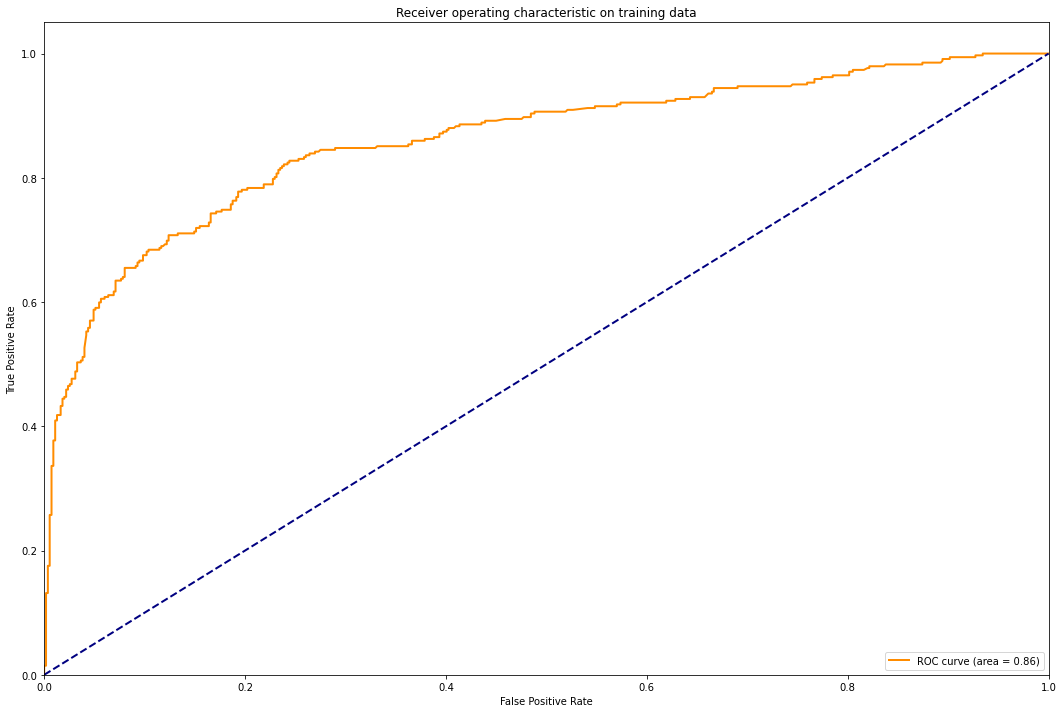

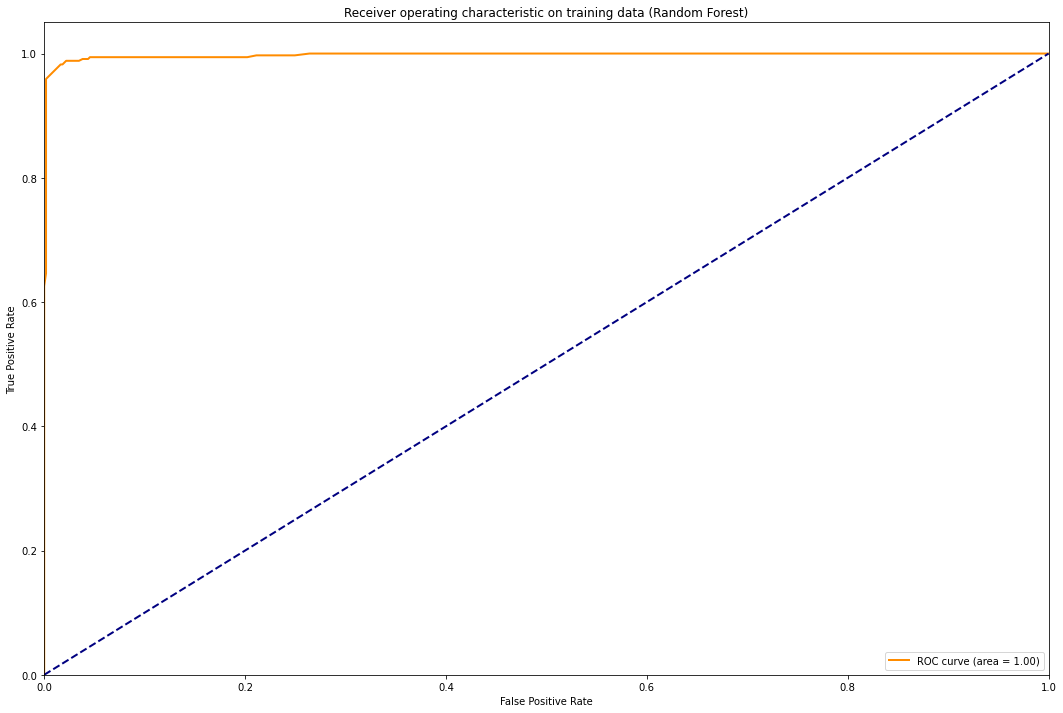

In [53]:
# Logistic Regression
y_score1 = model1.decision_function(X_train)
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_train, y_score1)
roc_auc = metrics.auc(fpr1, tpr1)
fig1 = plt.figure()
fignum = fig1.number
lw = 2
plt.plot(fpr1, tpr1, color='darkorange',
         lw=lw, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic on training data')
plt.legend(loc="lower right")
fig1.set_size_inches([figure_width, figure_height])
plt.show()

# Random Forest
y_score2 = model2.predict_proba(X_train)[:,1]
fpr2, tpr2, thresholds2 = metrics.roc_curve(y_train, y_score2)
roc_auc2 = metrics.auc(fpr2, tpr2)
fig2 = plt.figure()
fignum2 = fig2.number
lw = 2
plt.plot(fpr2, tpr2, color='darkorange',
         lw=lw, label=f'ROC curve (area = {roc_auc2:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic on training data (Random Forest)')
plt.legend(loc="lower right")
fig2.set_size_inches([figure_width, figure_height])
plt.show()

## Competition Submission
We choose the model we want to use to submit our test set preidction submission

In [55]:
# yhat_test = model1.predict(X_test)
# print(yhat_test)